In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt, sin, cos, exp
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor  
from multiprocessing import cpu_count  
from numba import jit
from scipy.optimize import least_squares  
from scipy.interpolate import griddata
import seaborn as sns
from matplotlib.colors import ListedColormap
import os


def read_normalized_coordinates(file_path):
    return np.loadtxt(file_path, skiprows=9, usecols=(0, 1, 2))

# Shape factor of spherical particles
@jit(nopython=True)  # Speed up calculations with numba
def spherical_scattering_factor(K, R):
    KR = K * R
    if KR == 0:
        return 1  
    return (3 * (sin(KR) - KR * cos(KR))) / (KR**3)

# Calculate the structure factor for each K-point
@jit(nopython=True)  # Speed up calculations with numba
def compute_structure_factor(K, particle_positions, R):
    Fatom1, Fatom2 = 0.0, 0.0
    for i in range(len(particle_positions)):
        x, y, z = particle_positions[i]
        K_value = sqrt(K[0]**2 + K[1]**2 + K[2]**2)
        Fatom = spherical_scattering_factor(K_value, R)
        inners = 2 * pi * (K[0] * x + K[1] * y + K[2] * z)
        Fatom1 += Fatom * cos(inners)
        Fatom2 += Fatom * sin(inners)
    return Fatom1, Fatom2


def calculate_para(prd, periodicity, Kmax, Zone):
    # Calculate the step size dK in reciprocal space and the maximum number of wave vectors Knmax
    prd_inv = np.zeros(3)  # Reciprocal space dimension
    ave_inv = 0.0
    # Calculate reciprocal space dimension based on periodicity
    for i in range(3):
        if periodicity[i]:
            prd_inv[i] = 1 / prd[i]
            ave_inv += prd_inv[i]
        else:
            prd_inv[i] = 1.0  # If there are no periodic boundary conditions, the default setting is 1.0.

    ave_inv /= sum(periodicity)  # Calculate the average in reciprocal space
    for i in range(3):
        if not periodicity[i]:
            prd_inv[i] = ave_inv  # For non-periodic directions, use the average reciprocal space dimension
    # Calculate the step size dK in reciprocal space
    dK = prd_inv * c  # Here c = [1, 1, 1], which can be adjusted as needed
    Knmax = np.ceil(Kmax / dK).astype(int)  # Calculate the maximum number of wave vectors
        # Ewald sphere radius and width definition
    R_Ewald = 1 / lambda_val  # Ewald sphere radius, usually the reciprocal of the wavelength
    dR_Ewald = 0.01 / 2  # Set the width of the Ewald sphere to a small numerical value as an example
    # Normalize Zone
    if Zone[0] != 0 or Zone[1] != 0 or Zone[2] != 0:
        Rnorm = R_Ewald / sqrt(Zone[0]**2 + Zone[1]**2 + Zone[2]**2)
        Zone[0] *= Rnorm
        Zone[1] *= Rnorm
        Zone[2] *= Rnorm
    else:
        raise ValueError("Zone cannot be a zero vector [0, 0, 0].")

    EmdR2 = pow(R_Ewald - dR_Ewald, 2)  # Calculate the points inside the Ewald sphere              
    EpdR2 = pow(R_Ewald + dR_Ewald, 2)

    return dK, Knmax, Zone, EmdR2, EpdR2

@jit(nopython=True)
def generate_K_points_chunk(i_start, i_end, j_start, j_end, k_start, k_end, dK, Kmax, Zone, EmdR2, EpdR2):
    store_tmp = []
    for i in range(i_start, i_end):
        for j in range(j_start, j_end):
            for k in range(k_start, k_end):
                K = np.array([i * dK[0], j * dK[1], k * dK[2]])
                dinv2 = np.sum(K**2)
                if dinv2 < Kmax**2:
                    r2 = 0.0
                    for m in range(3):
                        r2 += (K[m] - Zone[m])**2
                    if r2 > EmdR2 and r2 < EpdR2:
                        store_tmp.append((K[0], K[1], K[2]))
    return store_tmp


def calculate_structure_factor(idx_K):
    K = store_tmp[idx_K]
    Fatom1, Fatom2 = compute_structure_factor(K, particle_coordinates, R)
    return (Fatom1**2 + Fatom2**2) / len(particle_coordinates)  # The intensity is the sum of the squares of the complex components.

def residuals(params, points):
    cx, cy, cz = params 
    distances = np.sqrt((points[:, 0] - cx)**2 + (points[:, 1] - cy)**2 + (points[:, 2] - cz)**2)
    return distances**2 - np.mean(distances**2)

In [2]:
# load data file
folder_path = r'F:\experiment\lammps simulation\20250424\1\capture'
file_name = 'hcp-1.9855.xyz'
file_path = fr'{folder_path}\{file_name}'
lambda_val = 0.633  # light wavelength (unit: um)
Kmax = 2  # max vector unit: um-1（2*sin(45)/0.6325 ）
Zone0 = [0, 0, 1]  
R = 0.5  # radius of particles (unit: um)

c = np.array([0.1, 0.1, 0.1]) #Grid fineness adjustment: the smaller the value, the finer the grid.
prd = np.array([20, 20, 20])  # Particle range size, unit: um
    # Periodic boundary conditions
periodicity = [True, True, True]  # Periodic boundary conditions in x, y, z directions 
particle_coordinates = read_normalized_coordinates(file_path)
#calculate parameters
dK, Knmax, Zone, EmdR2, EpdR2 = calculate_para(prd, periodicity, Kmax, Zone0)


In [3]:
from concurrent.futures import ProcessPoolExecutor
import itertools

# Create task parameter list
tasks = [
    (-Knmax[0], 0, -Knmax[1], 0, -Knmax[2], 0),
    (-Knmax[0], 0, -Knmax[1], 0, 0, Knmax[2]),
    (-Knmax[0], 0, 0, Knmax[1], -Knmax[2], 0),
    (-Knmax[0], 0, 0, Knmax[1], 0, Knmax[2]),
    (0, Knmax[0], -Knmax[1], 0, -Knmax[2], 0),
    (0, Knmax[0], -Knmax[1], 0, 0, Knmax[2]),
    (0, Knmax[0], 0, Knmax[1], -Knmax[2], 0),
    (0, Knmax[0], 0, Knmax[1], 0, Knmax[2])
]

# Parallel computation of K-points using a process pool
with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
    # Create a list of Future objects
    futures = [
        executor.submit(generate_K_points_chunk, *task, dK, Kmax, Zone, EmdR2, EpdR2)
        for task in tasks
    ]
    # Use tqdm to display progress
    results = list(tqdm(
        [future.result() for future in futures],
        total=len(futures),
        desc="Generating K points"
    ))

# Merge the results of all processes
store_tmp = list(itertools.chain(*results))

Generating K points: 100%|██████████| 8/8 [00:00<?, ?it/s]


In [ ]:
nRows = len(store_tmp)
diffraction_pattern = np.zeros(nRows)
#Parallel computing of structure factors for all K-points using process pools
with ThreadPoolExecutor(max_workers=cpu_count()) as executor:
    results = list(tqdm(executor.map(calculate_structure_factor, range(nRows)), total=nRows, desc="Computing Structure Factors"))

#Fill the results into the diffraction pattern
diffraction_pattern[:] = results

Computing Structure Factors: 100%|██████████| 1004317/1004317 [02:15<00:00, 7387.95it/s]


In [5]:

# Project the three-dimensional position onto a two-dimensional plane
points = np.array(store_tmp)
initial_guess = np.mean(points, axis=0)
result = least_squares(residuals, initial_guess, args=(points,))
ball_center = result.x
distances = np.sqrt(np.sum((points - ball_center) ** 2, axis=1))
r = np.mean(distances)
converted_points = []
for point in points:
    x1, y1, z1 = point - ball_center
    theta = np.arccos(-z1 / ((y1**2+z1**2)**0.5))
    phi = np.arccos(-z1 / ((x1**2+z1**2)**0.5))
    if y1 <= 0:
        y = - r*theta
    else:
        y = r*theta
    if x1 <= 0:
        x = -r*phi
    else:
        x = r*phi
    converted_points.append([x, y])
converted_points = np.array(converted_points)


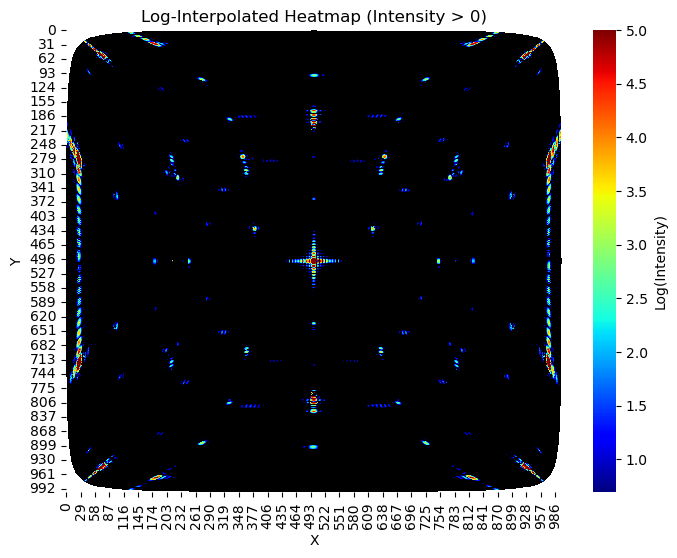

In [ ]:
# Draw and save 2D simulated scattering plots
x_vals = converted_points[:, 0] 
y_vals = converted_points[:, 1] 
intensity_vals = diffraction_pattern 
intensity_vals_log = np.log1p(intensity_vals)

# Set the range and density of the target grid
grid_x, grid_y = np.meshgrid(
    np.linspace(-max(x_vals), max(x_vals), 1000),  
    np.linspace(-max(x_vals), max(x_vals), 1000)  
)

# Use griddata for interpolation to map irregular point sets onto a uniform grid
grid_intensity = griddata(
    (x_vals, y_vals), intensity_vals_log, 
    (grid_x, grid_y), method='cubic'  # 'linear', 'nearest', or 'cubic' 
)

# set plot parameters
threshold = np.log1p(1)  
masked_grid_intensity = np.ma.masked_where(grid_intensity < threshold, grid_intensity)
cmap = plt.get_cmap('jet')  
new_cmap = ListedColormap(cmap(np.linspace(0, 1, cmap.N)))  
new_cmap.set_under(color='black')

plt.figure(figsize=(8, 6))
sns.heatmap(masked_grid_intensity, cmap=new_cmap, cbar=True, vmin=threshold, vmax=5, cbar_kws={'label': 'Log(Intensity)'})
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Log-Interpolated Heatmap (Intensity > 0)")

# save plot
base_name, _ = os.path.splitext(file_name)
base_name = file_name.split('.')[0] 
save_path = fr'{folder_path}\diffraction_pattern-{base_name}.jpg'
plt.savefig(save_path, dpi=600, bbox_inches='tight', pad_inches=0.1) 
plt.show()
